# Initialization

In [1]:
%reload_ext autoreload
%autoreload 2

In [2]:
from result_saver import SaverProvider

provider = SaverProvider()

# Generate Extreme Data

In [3]:
from soft_info import RepCodeIQSimulator

DEVICE = 'ibm_sherbrooke'
DISTANCE = 5
ROUNDS = 5
OTHER_DATE = '2021-11-11'
_RESETS = True
LOGICAL = 0 # NOT NEEDED FOR EXTREME IQ BCS HARDCODED 0

_is_hex = True
if DEVICE == 'ibmq_mumbai':
    _is_hex = False

# Initialize simulator
simulator = RepCodeIQSimulator(provider, DISTANCE, ROUNDS, DEVICE, _is_hex=_is_hex, _resets = _RESETS, other_date=OTHER_DATE)

Found jobs for backend ibm_sherbrooke with closest execution date 2023-10-27 08:32:22.841567+00:00.
Found jobs for backend ibm_sherbrooke with closest execution date 2023-10-27 08:32:22.841567+00:00.
Searching for ibm_sherbrooke and 23.10.27_07h46_300pts_2std


In [4]:
# Get noise model
p1Q = 0
pZ = 0
pRE = 0
pXY = 0

p2Q = 1e-2
# pRO = 15e-2
pRO = 0


p1Q = 1e-4
p2Q = 8e-3
pXY = 1e-4
pZ = 1e-4
pRO = 0.8e-2 # slightly lower than device median because no soft flips
pRE = 1e-3

noise_model = simulator.get_noise_model(p1Q, p2Q, pXY, pZ, pRO, pRE)

In [31]:
SHOTS = int(1e4)
P_AMBIG = 0.2

extreme_IQ_data = simulator.generate_extreme_IQ(SHOTS, P_AMBIG, noise_model=noise_model)
print(extreme_IQ_data.shape)

15:27:50 Warning: Getting counts via stim. This may take time.... IN FILE: /Users/mha/My_Drive/Desktop/Studium/Physik/MSc/Semester_3/IBM/IBM_GIT/Soft-Info/src/soft_info/IQ_data/simulator.py, LINE: 51


100%|██████████| 4357/4357 [00:01<00:00, 2625.02it/s]

(10000, 25)


# Get counts from IQ data

In [32]:
import cpp_soft_info

print(cpp_soft_info.get_counts(extreme_IQ_data, simulator.qubit_mapping, simulator.grid_dict, simulator.processed_scaler_dict, ROUNDS))

{'00000 0000 0000 0000 0000 0000': 14, '00000 0000 0000 0000 0000 0001': 6, '00000 0000 0000 0000 0000 0010': 3, '00000 0000 0000 0000 0000 0100': 6, '00000 0000 0000 0000 0000 0101': 2, '00000 0000 0000 0000 0000 0110': 2, '00000 0000 0000 0000 0000 0111': 1, '00000 0000 0000 0000 0000 1000': 6, '00000 0000 0000 0000 0000 1001': 4, '00000 0000 0000 0000 0000 1011': 1, '00000 0000 0000 0000 0000 1100': 2, '00000 0000 0000 0000 0000 1101': 1, '00000 0000 0000 0000 0001 0000': 2, '00000 0000 0000 0000 0001 0001': 2, '00000 0000 0000 0000 0001 0010': 2, '00000 0000 0000 0000 0001 0100': 3, '00000 0000 0000 0000 0001 0110': 1, '00000 0000 0000 0000 0001 1000': 2, '00000 0000 0000 0000 0001 1100': 3, '00000 0000 0000 0000 0010 0000': 4, '00000 0000 0000 0000 0010 0001': 1, '00000 0000 0000 0000 0010 0010': 2, '00000 0000 0000 0000 0010 0011': 1, '00000 0000 0000 0000 0010 0100': 1, '00000 0000 0000 0000 0010 0101': 1, '00000 0000 0000 0000 0010 1000': 1, '00000 0000 0000 0000 0010 1001': 1,

# Decode IQ data

In [33]:
import pymatching
import stim


circuit = stim.Circuit.generated("repetition_code:memory",
                                distance=DISTANCE,
                                rounds=ROUNDS,
                                after_clifford_depolarization=p2Q, #two-qubit-fidelity,
                                after_reset_flip_probability=pRE, #reset error,
                                before_measure_flip_probability=pRO, #measurement error,
                                before_round_data_depolarization=(pXY+pZ)/2) #idle error)
# print(circuit)

model = circuit.detector_error_model(decompose_errors=True)
matching = pymatching.Matching.from_detector_error_model(model)

P_DATA = 1e-2
P_MIXED = 1e-2
P_MEAS = P_AMBIG

In [34]:
import cpp_soft_info

matching = pymatching.Matching.from_detector_error_model(model)
# cpp_soft_info.reweight_edges_based_on_error_probs(matching._matching_graph, counts, False, "spitz")

result = cpp_soft_info.decode_IQ_shots(matching._matching_graph, extreme_IQ_data,
                                           ROUNDS, int(LOGICAL), _RESETS, simulator.qubit_mapping, simulator.grid_dict,
                                           simulator.processed_scaler_dict, p_data=-1, p_mixed=-1,
                                           common_measure=-1, _bimodal=True, merge_strategy = "replace", _detailed=True)
print("num_errors:", result.num_errors, "out of", len(extreme_IQ_data), "shots")

num_errors: 82 out of 10000 shots


In [35]:
matching = pymatching.Matching.from_detector_error_model(model)
result_flat = cpp_soft_info.decode_IQ_shots_flat(matching._matching_graph, extreme_IQ_data,
                                           ROUNDS, int(LOGICAL), _RESETS, simulator.qubit_mapping, simulator.grid_dict,
                                           simulator.processed_scaler_dict, _detailed=True)
print("num_errors:", result_flat.num_errors, "out of", len(extreme_IQ_data), "shots")


num_errors: 1016 out of 10000 shots


In [36]:
matching = pymatching.Matching.from_detector_error_model(model)

p_meas = P_MEAS
# p_meas = 0e-2

result_informed = cpp_soft_info.decode_IQ_shots_flat_informed(matching._matching_graph, extreme_IQ_data, 
                                           ROUNDS, int(LOGICAL), _RESETS, simulator.qubit_mapping, simulator.grid_dict, simulator.processed_scaler_dict,
                                           p_data = -1, p_mixed = -1, p_meas = -1, common_measure=-1, _detailed=True)

print("num_errors:", result_informed.num_errors, "out of", len(extreme_IQ_data), "shots")
         
# takes 1s

num_errors: 128 out of 10000 shots


# Plot the results

In [37]:
print("\nIQ:", result.indices, "\nFlat:", result_flat.indices, "\nInformed", result_informed.indices)


IQ: [1340, 1364, 1454, 1536, 2257, 3059, 3449, 4018, 5184, 5268, 5326, 5416, 5745, 5859, 5947, 6003, 6046, 6104, 6220, 6223, 6298, 6313, 6621, 6654, 6756, 7042, 7128, 7130, 7210, 7223, 7224, 7370, 7484, 7498, 7827, 7843, 7873, 7898, 8030, 8064, 8083, 8239, 8251, 8311, 8451, 8457, 8507, 8521, 8627, 8644, 8680, 8736, 8741, 8758, 8791, 8836, 8855, 8914, 8940, 8975, 9025, 9060, 9069, 9070, 9086, 9239, 9350, 9352, 9354, 9397, 9432, 9498, 9507, 9537, 9545, 9597, 9607, 9653, 9707, 9836, 9960, 9994] 
Flat: [30, 84, 209, 288, 430, 601, 626, 656, 663, 679, 696, 702, 703, 704, 716, 721, 735, 771, 785, 831, 850, 906, 925, 945, 953, 976, 980, 982, 1026, 1062, 1121, 1122, 1124, 1131, 1141, 1149, 1180, 1189, 1217, 1289, 1362, 1406, 1411, 1412, 1461, 1550, 1570, 1591, 1604, 1722, 1723, 1724, 1729, 1730, 1744, 1771, 1781, 1800, 1811, 1848, 1854, 1878, 1896, 1899, 1907, 1911, 1915, 1943, 1962, 1973, 1980, 1992, 2025, 2027, 2046, 2051, 2110, 2172, 2179, 2184, 2207, 2220, 2223, 2257, 2264, 2287, 2386, 24

-----IQ-----


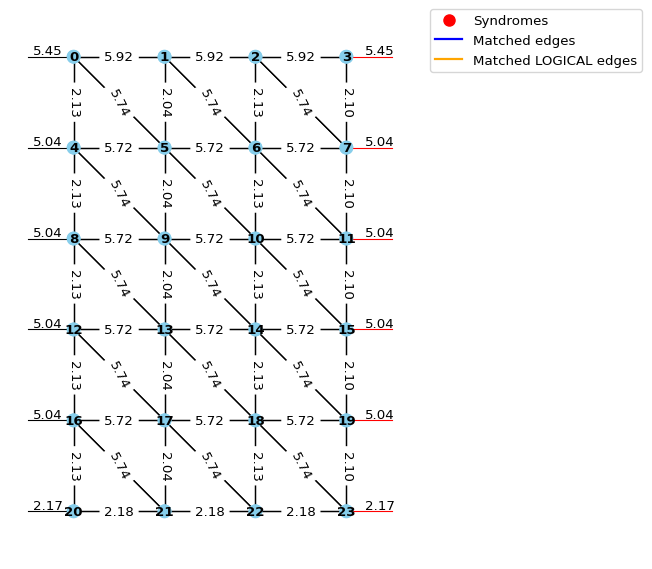

-----flat-----


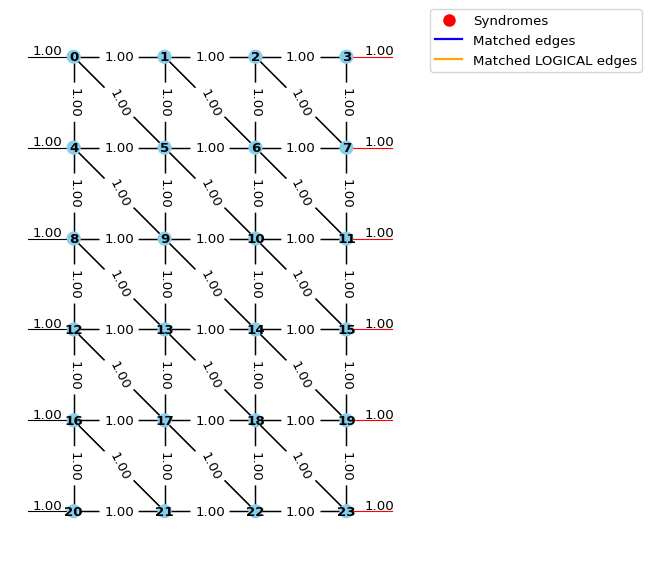

-----INFORMED-----


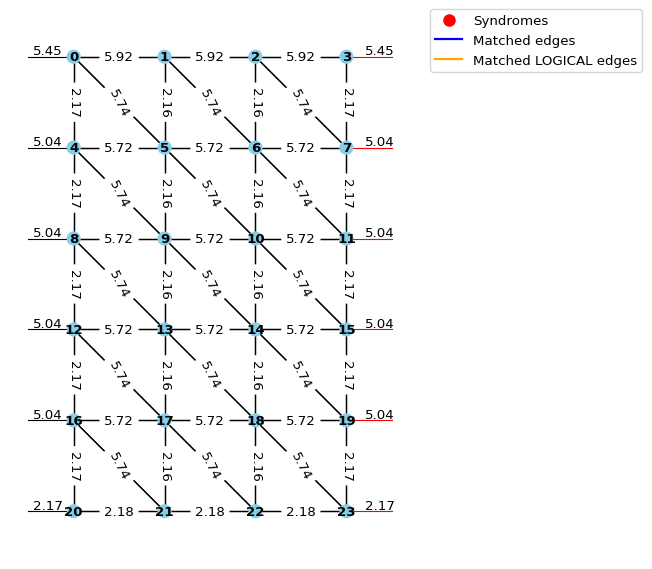

In [23]:
from soft_info import draw_matching_graph


index = 100

fig_size = (4, 13)
scale_factor = 0.8

to_be_result = result
details = to_be_result.error_details[index]
print("-----IQ-----")
draw_matching_graph(matching=None, d=DISTANCE, T=ROUNDS, syndromes=details.detection_syndromes,
                        matched_edges=details.matched_edges, figsize=fig_size, scale_factor=scale_factor, edge_list=details.edges)

to_be_result = result_flat
details = to_be_result.error_details[index]
print("-----flat-----")
draw_matching_graph(matching=None, d=DISTANCE, T=ROUNDS, syndromes=details.detection_syndromes,
                        matched_edges=details.matched_edges, figsize=fig_size, scale_factor=scale_factor, edge_list=details.edges)

to_be_result = result_informed
details = to_be_result.error_details[index]
print("-----INFORMED-----")
draw_matching_graph(matching=None, d=DISTANCE, T=ROUNDS, syndromes=details.detection_syndromes,
                        matched_edges=details.matched_edges, figsize=fig_size, scale_factor=scale_factor, edge_list=details.edges)


In [24]:
# print the differences between the two lists using sets
print("diff between IQ and informed:")
print(set(result_informed.indices) - set(result.indices))
print(set(result.indices) - set(result_informed.indices))

print()
print("diff between flat and informed:")
print(set(result.indices) - set(result_flat.indices))
print(set(result_flat.indices) - set(result.indices))



diff between IQ and informed:
set()
set()

diff between flat and informed:
set()
set()
